##### Imports

In [38]:
# %pip install -r requirements.txt

In [39]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal
import pickle

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

from regime_detection import KAMA
from regime_detection import MarkovSwitchingModel
from regime_detection import KAMA_MSR

# Testing KAMA+MSR

In [28]:
# Prepare data
sdte = datetime(1990, 1, 1)
edte = datetime(2018, 1, 1)
symbol_name_dict = pd.read_csv('data/inputs/fmp_index_list.csv').set_index('symbol')['name'].to_dict()
index_data = pd.read_csv('data/processed/index_data.csv', index_col=0, header=[0, 1], parse_dates=True)

index_close_cols = index_data.columns[index_data.columns.get_level_values(1) == 'close']
index_close_prices = index_data[index_close_cols].droplevel(1, axis=1).rename(columns=symbol_name_dict)
index_close_prices.columns

Index(['S&P/TSX Composite Index', 'TSEC Weighted Index', 'S&P/ASX 200',
       'S&P 500', 'Nikkei 225', 'KOSPI Composite Index', 'FTSE MIB Index',
       'FTSE 100', 'SMI PR', 'NIFTY 50', 'NASDAQ 100', 'DAX Performance Index',
       'CAC 40', 'MSCI_China'],
      dtype='object')

### STEP 1: DATA PREPARATION

In [29]:
# ============================================================================
# STEP 1: DATA PREPARATION
# ============================================================================
print("="*80)
print("KAMA+MSR COMPREHENSIVE ANALYSIS WORKFLOW")
print("="*80)

# Prepare data
sdte = datetime(1990, 1, 1)
edte = datetime(2016, 1, 1)
symbol_name_dict = pd.read_csv('data/inputs/fmp_index_list.csv').set_index('symbol')['name'].to_dict()
index_data = pd.read_csv('data/processed/index_data.csv', index_col=0, header=[0, 1], parse_dates=True)

index_close_cols = index_data.columns[index_data.columns.get_level_values(1) == 'close']
index_close_prices = index_data[index_close_cols].droplevel(1, axis=1).rename(columns=symbol_name_dict)

# Params
asset_name = 'S&P 500'
n_samples=500
burnin=100
thin=1
n_regimes=2
use_three_state_msr = (n_regimes == 3)

prices = index_close_prices[asset_name].dropna()
prices = prices.loc[sdte:edte]
log_returns = np.log(prices).diff().dropna()
data_df = pd.DataFrame({
    'prices': prices,
    'returns': log_returns
})

print(f"\nData Period: {prices.index[0]} to {prices.index[-1]}")
print(f"Total Observations: {len(prices)}")

KAMA+MSR COMPREHENSIVE ANALYSIS WORKFLOW

Data Period: 1990-01-02 00:00:00 to 2015-12-31 00:00:00
Total Observations: 6553


### STEP 2: INITIALIZE AND FIT MODEL

In [30]:
# ============================================================================
# STEP 2: INITIALIZE AND FIT MODEL
# ============================================================================

# Default MSR Priors:
    # 'mean_prior_mean': 0.0,
    # 'mean_prior_var': 0.1,
    # 'beta_prior_mean': 0.0,
    # 'beta_prior_var': 1.0,
    # 'sigma_prior_shape': 2.0,
    # 'sigma_prior_scale': 0.1,
    # 'transition_prior_alpha': 8.0
optimize_priors = False
priors_to_optimize = ['transition'] # can inlude: transition, sigma, mean, beta (in that priority order)
# Will usually only optimize transition prior and maybe sigma priors

print("\n" + "="*80)
print("STEP 1: MODEL INITIALIZATION AND FITTING")
print("="*80)

# Initialize model
model = KAMA_MSR(
    kama_params={'n': 10, 'n_fast': 2, 'n_slow': 30},
    msr_params={'n_regimes': n_regimes},
    filter_params={'n_lookback': 20, 'gamma': 0.7},
    use_three_state_msr=use_three_state_msr
)

# Fit the model
model.fit(
    prices, 
    optimize_kama=True,      # Set True to optimize KAMA params
    optimize_filter=True,    # Set True to optimize filter params
    msr_verbose=True,
    n_samples=n_samples,
    burnin=burnin,
    thin=thin
)


STEP 1: MODEL INITIALIZATION AND FITTING
KAMA+MSR COMBINED MODEL FITTING
Mode: 4-Regime (2-State MSR)

[1/4] Fitting 2-state MSR model...
Running Gibbs sampler: 600 total iterations
Burnin: 100, Samples: 500, Thin: 1
Iteration 100/600
Iteration 200/600
Iteration 300/600
Iteration 400/600
Iteration 500/600
Iteration 600/600

Gibbs sampling completed!
Regime 0: μ=0.000426, β=-0.0065, σ=0.010649
Regime 1: μ=-0.001919, β=-0.0303, σ=0.035317

[2/4] Optimizing KAMA parameters...
   Optimized KAMA: n=10, n_fast=2, n_slow=30

[3/4] Calculating KAMA and filter...

[4/4] Classifying into 4 regimes...

Model fitting complete!

REGIME CLASSIFICATION SUMMARY
Regime 0 (Low Variance + Bullish): 3254 periods (49.7%)
Regime 1 (Low Variance + Bearish): 2846 periods (43.4%)
Regime 2 (High Variance + Bullish): 66 periods (1.0%)
Regime 3 (High Variance + Bearish): 367 periods (5.6%)

Total regime changes: 286
Average regime duration: 22.8 periods

[Optional] Optimizing filter parameters...

Optimizing fil

### STEP 2.B: OPTIMIZE MSR PRIORS

In [31]:
# ============================================================================
# STEP 2.B: OPTIMIZE MSR PRIORS
# ============================================================================

if optimize_priors:
    print("\n" + "="*80)
    print("STEP 2.B: MSR PRIOR OPTIMIZATION")
    print("="*80)

    # MSR PRIOR OPTIONS
    mean_prior_mean_options = [0.0, 0.0005, 0.001]
    mean_prior_var_options = [0.01, 0.1, 0.5]
    beta_prior_mean_options = [-0.1, 0.0, 0.1]
    beta_prior_var_options = [0.01, 0.1, 0.5]
    sigma_prior_shape_options = [1.1, 2.0, 5.0]
    sigma_prior_scale_options = [0.03, 0.1, 0.3]
    transition_prior_alpha_options = [2.0, 8.0, 20.0]

    if 'transition' in priors_to_optimize:
        print("\n" + "="*80)
        print("OPTIMIZING TRANSITION PRIOR (Regime Persistence)")
        print("="*80)

        regime_labels_before = model.regime_labels.copy()

        # Define parameter grid for transition_prior_alpha
        param_grid_persistence = {
            'transition_prior_alpha': transition_prior_alpha_options
        }

        # Optimize transition prior
        best_persistence = model.optimize_msr_priors(
            prices=prices,
            returns=log_returns,
            param_grid=param_grid_persistence,
            method='grid'
        )

        # Get updated regime labels after optimization
        regime_labels_after = model.regime_labels.copy()

        # Now calculate changes using the saved copies
        before_changes = (regime_labels_before.diff() != 0).sum()
        after_changes = (regime_labels_after.diff() != 0).sum()

        print(f"\nBest transition prior: {best_persistence['transition_prior_alpha']}")
        print(f"Regime changes before: {before_changes}")
        print(f"Regime changes after:  {after_changes}")
        print(f"Change reduction: {(1 - after_changes/before_changes)*100:.1f}%")

    if 'sigma' in priors_to_optimize:
        print("\n" + "="*80)
        print("OPTIMIZING VOLATILITY PRIORS")
        print("="*80)

        # Define parameter grid for volatility parameters
        param_grid_volatility = {
            'sigma_prior_scale': sigma_prior_scale_options,
            'sigma_prior_shape': sigma_prior_shape_options
        }

        # Optimize volatility priors
        best_volatility = model.optimize_msr_priors(
            prices=prices,
            returns=log_returns,
            param_grid=param_grid_volatility,
            method='grid'
        )

        # Get updated labels
        regime_labels_after_volatility = model.regime_labels.copy()

        print(f"\nBest sigma priors:")
        print(f"  sigma_prior_scale: {best_volatility['sigma_prior_scale']:.3f}")
        print(f"  sigma_prior_shape: {best_volatility['sigma_prior_shape']:.3f}")

    if 'mean' in priors_to_optimize:
        print("\n" + "="*80)
        print("OPTIMIZING MEAN PRIORS (Optional)")
        print("="*80)

        # Define parameter grid for mean parameters
        param_grid_mean = {
            'mean_prior_mean': mean_prior_mean_options,
            'mean_prior_var': mean_prior_var_options
        }

        # Optimize mean priors
        best_mean = model.optimize_msr_priors(
            prices=prices,
            returns=log_returns,
            param_grid=param_grid_mean,
            method='grid'
        )

        # Get updated labels
        regime_labels_after_mean = model.regime_labels.copy()

        print(f"\nBest mean priors:")
        print(f"  mean_prior_mean: {best_mean['mean_prior_mean']:.5f}")
        print(f"  mean_prior_var: {best_mean['mean_prior_var']:.3f}")
    
    if 'beta' in priors_to_optimize:
        print("\n" + "="*80)
        print("OPTIMIZING BETA PRIORS (Optional)")
        print("="*80)

        # Define parameter grid for beta parameters
        param_grid_beta = {
            'beta_prior_mean': beta_prior_mean_options,
            'beta_prior_var': beta_prior_var_options
        }

        # Optimize beta priors
        best_beta = model.optimize_msr_priors(
            prices=prices,
            returns=log_returns,
            param_grid=param_grid_beta,
            method='grid'
        )

        # Get updated labels
        regime_labels_after_beta = model.regime_labels.copy()

        print(f"\nBest beta priors:")
        print(f"  beta_prior_mean: {best_beta['beta_prior_mean']:.3f}")
        print(f"  beta_prior_var: {best_beta['beta_prior_var']:.3f}")

### STEPS 3 & 4: ANALYZE MODEL PARAMETERS, REGIME CLASSIFICATION, REGIME CHARACTERISTICS, AND STATISTICS

In [32]:
# ============================================================================
# STEP 3: ANALYZE MODEL PARAMETERS AND REGIME CLASSIFICATION
# ============================================================================
print("\n" + "="*80)
print("STEP 3: PARAMETER ANALYSIS & REGIME SUMMARY")
print("="*80)

# Comprehensive parameter analysis
regime_probs = model.analyze_results(data=data_df, data_name="S&P 500")

# ============================================================================
# STEP 4: REGIME CHARACTERISTICS AND STATISTICS
# ============================================================================
print("\n" + "="*80)
print("STEP 3: DETAILED REGIME CHARACTERISTICS")
print("="*80)

# Detailed regime-specific return/volatility analysis
regime_classification = model.regime_characteristics(
    data=data_df,
    regime_probs=regime_probs,
    data_name="S&P 500"
)


STEP 3: PARAMETER ANALYSIS & REGIME SUMMARY

KAMA+MSR ANALYSIS RESULTS FOR S&P 500

MSR Parameters (Underlying 2-state model):
Regime   μ (Mean)     β (AR)     σ (Vol)     
---------------------------------------------
Regime 0  0.000426    -0.0065   0.010649   
Regime 1  -0.001919   -0.0303   0.035317   

MSR Transition Probabilities:
From\To  Reg 0  Reg 1
---------------------
Regime 0  0.995  0.005
Regime 1  0.064  0.936

KAMA Parameters:
  n (ER period): 10
  n_fast: 2
  n_slow: 30

KAMA Filter Parameters:
  n_lookback: 20
  gamma: 0.7

Combined Regime Classification (4 regimes):
Regime 0 periods: 3254 days (49.8%)
Regime 1 periods: 2846 days (43.6%)
Regime 2 periods: 66 days (1.0%)
Regime 3 periods: 367 days (5.6%)
Number of regime changes: 286

STEP 3: DETAILED REGIME CHARACTERISTICS

DETAILED REGIME ANALYSIS - S&P 500

Low Vol Bullish (Regime 0):
  Observations: 3254 (49.7%)
  Regime Segments: 126
  Average Duration: 25.8 periods
  Minimum Duration: 1 periods
  Maximum Duration

### STEP 5: MODEL DIAGNOSTICS

In [33]:
# ============================================================================
# STEP 5: MODEL DIAGNOSTICS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: MODEL DIAGNOSTICS & VALIDATION")
print("="*80)

# Run diagnostics (with MCMC trace plots if desired)
model.diagnostics(
    data=data_df,
    regime_probs=regime_probs,
    data_name="S&P 500",
    trace_plots=True  # Set False to skip trace plots
)


STEP 5: MODEL DIAGNOSTICS & VALIDATION

KAMA+MSR MODEL DIAGNOSTICS - S&P 500

Combined Model Fit Statistics:
Log-Likelihood: 20618.50
Average Log-Likelihood: 3.15

KAMA Tracking Error (vs returns): 0.010495
KAMA Efficiency Ratio (mean): 0.3125

Regime Stability:
  Total regime changes: 286
  Average regime duration: 22.8 periods
  Change frequency: 4.37%


### STEPS 6 & (7): GENERATE TRADING SIGNALS & (BACKTEST PERFORMANCE)

In [34]:
# ============================================================================
# STEP 6: GENERATE TRADING SIGNALS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: TRADING SIGNAL GENERATION")
print("="*80)

# Get default trading signals (LV Bullish long, HV Bearish short)
signals = model.get_trading_signals()  

# Or customize active regimes
# signals = model.get_trading_signals(active_regimes=[0, 3])  # Default
# signals = model.get_trading_signals(active_regimes=[0, 2, 3])  # All bull + HV bear

print(f"\nTrading Signal Summary:")
print(f"  Long positions:    {(signals == 1).sum()} days ({(signals == 1).sum()/len(signals)*100:.1f}%)")
print(f"  Short positions:   {(signals == -1).sum()} days ({(signals == -1).sum()/len(signals)*100:.1f}%)")
print(f"  Neutral positions: {(signals == 0).sum()} days ({(signals == 0).sum()/len(signals)*100:.1f}%)")

'''
# ============================================================================
# STEP 7: BACKTEST PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("STEP 6: STRATEGY BACKTEST")
print("="*80)

# Align signals with returns
aligned_signals = signals.reindex(sp500_returns.index, fill_value=0)

# Calculate strategy returns
strategy_returns = aligned_signals * sp500_returns
cumulative_strategy = strategy_returns.cumsum()
cumulative_benchmark = sp500_returns.cumsum()

# Performance metrics
print(f"\nStrategy Performance:")
print(f"  Total Return:      {(np.exp(cumulative_strategy.iloc[-1])-1)*100:.2f}%")
print(f"  Annualized Return: {strategy_returns.mean()*252*100:.2f}%")
print(f"  Annualized Vol:    {strategy_returns.std()*np.sqrt(252)*100:.2f}%")
print(f"  Sharpe Ratio:      {(strategy_returns.mean()/strategy_returns.std()*np.sqrt(252)):.3f}")
print(f"  Max Drawdown:      {((cumulative_strategy - cumulative_strategy.cummax()).min())*100:.2f}%")

print(f"\nBenchmark (Buy & Hold) Performance:")
print(f"  Total Return:      {(np.exp(cumulative_benchmark.iloc[-1])-1)*100:.2f}%")
print(f"  Annualized Return: {sp500_returns.mean()*252*100:.2f}%")
print(f"  Annualized Vol:    {sp500_returns.std()*np.sqrt(252)*100:.2f}%")
print(f"  Sharpe Ratio:      {(sp500_returns.mean()/sp500_returns.std()*np.sqrt(252)):.3f}")
print(f"  Max Drawdown:      {((cumulative_benchmark - cumulative_benchmark.cummax()).min())*100:.2f}%")

# Regime-specific performance
print(f"\nPerformance by Regime:")
for regime in range(model.n_combined_regimes):
    regime_mask = (model.regime_labels == regime)
    regime_returns = sp500_returns.loc[model.regime_labels.index[regime_mask]]
    if len(regime_returns) > 0:
        regime_sharpe = regime_returns.mean() / regime_returns.std() * np.sqrt(252)
        print(f"  Regime {regime}: Sharpe = {regime_sharpe:.3f}, "
              f"Periods = {len(regime_returns)}")

# ============================================================================
# STEP 8: VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("STEP 7: GENERATING VISUALIZATIONS")
print("="*80)

# Main regime classification plot
print("\n[1/3] Regime Classification Plot...")
model.plot_regimes(figsize=(16, 12))

# Comprehensive analysis plot
print("[2/3] Comprehensive Analysis Plot...")
model.plot_comprehensive_analysis(
    data=data_df,
    regime_probs=regime_probs,
    data_name="S&P 500"
)

# Strategy performance plot
print("[3/3] Strategy Performance Plot...")
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0]
ax1.plot(cumulative_strategy.index, np.exp(cumulative_strategy)-1, 
         label='KAMA+MSR Strategy', linewidth=2, color='blue')
ax1.plot(cumulative_benchmark.index, np.exp(cumulative_benchmark)-1, 
         label='Buy & Hold', linewidth=2, alpha=0.7, color='gray')
ax1.set_title('Cumulative Returns: KAMA+MSR Strategy vs Buy & Hold', fontsize=14, weight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Drawdown
ax2 = axes[1]
strategy_dd = cumulative_strategy - cumulative_strategy.cummax()
benchmark_dd = cumulative_benchmark - cumulative_benchmark.cummax()
ax2.fill_between(strategy_dd.index, strategy_dd, 0, 
                 alpha=0.7, color='blue', label='Strategy Drawdown')
ax2.fill_between(benchmark_dd.index, benchmark_dd, 0, 
                 alpha=0.4, color='gray', label='Benchmark Drawdown')
ax2.set_title('Drawdown Analysis', fontsize=14, weight='bold')
ax2.set_ylabel('Drawdown')
ax2.set_xlabel('Date')
ax2.legend(loc='lower left', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
'''
print()


STEP 5: TRADING SIGNAL GENERATION

Trading Signal Summary:
  Long positions:    3254 days (49.7%)
  Short positions:   367 days (5.6%)
  Neutral positions: 2931 days (44.7%)



### STEP 8: VISUALIZATIONS


STEP 7: GENERATING VISUALIZATIONS

[1/3] Regime Classification Plot...


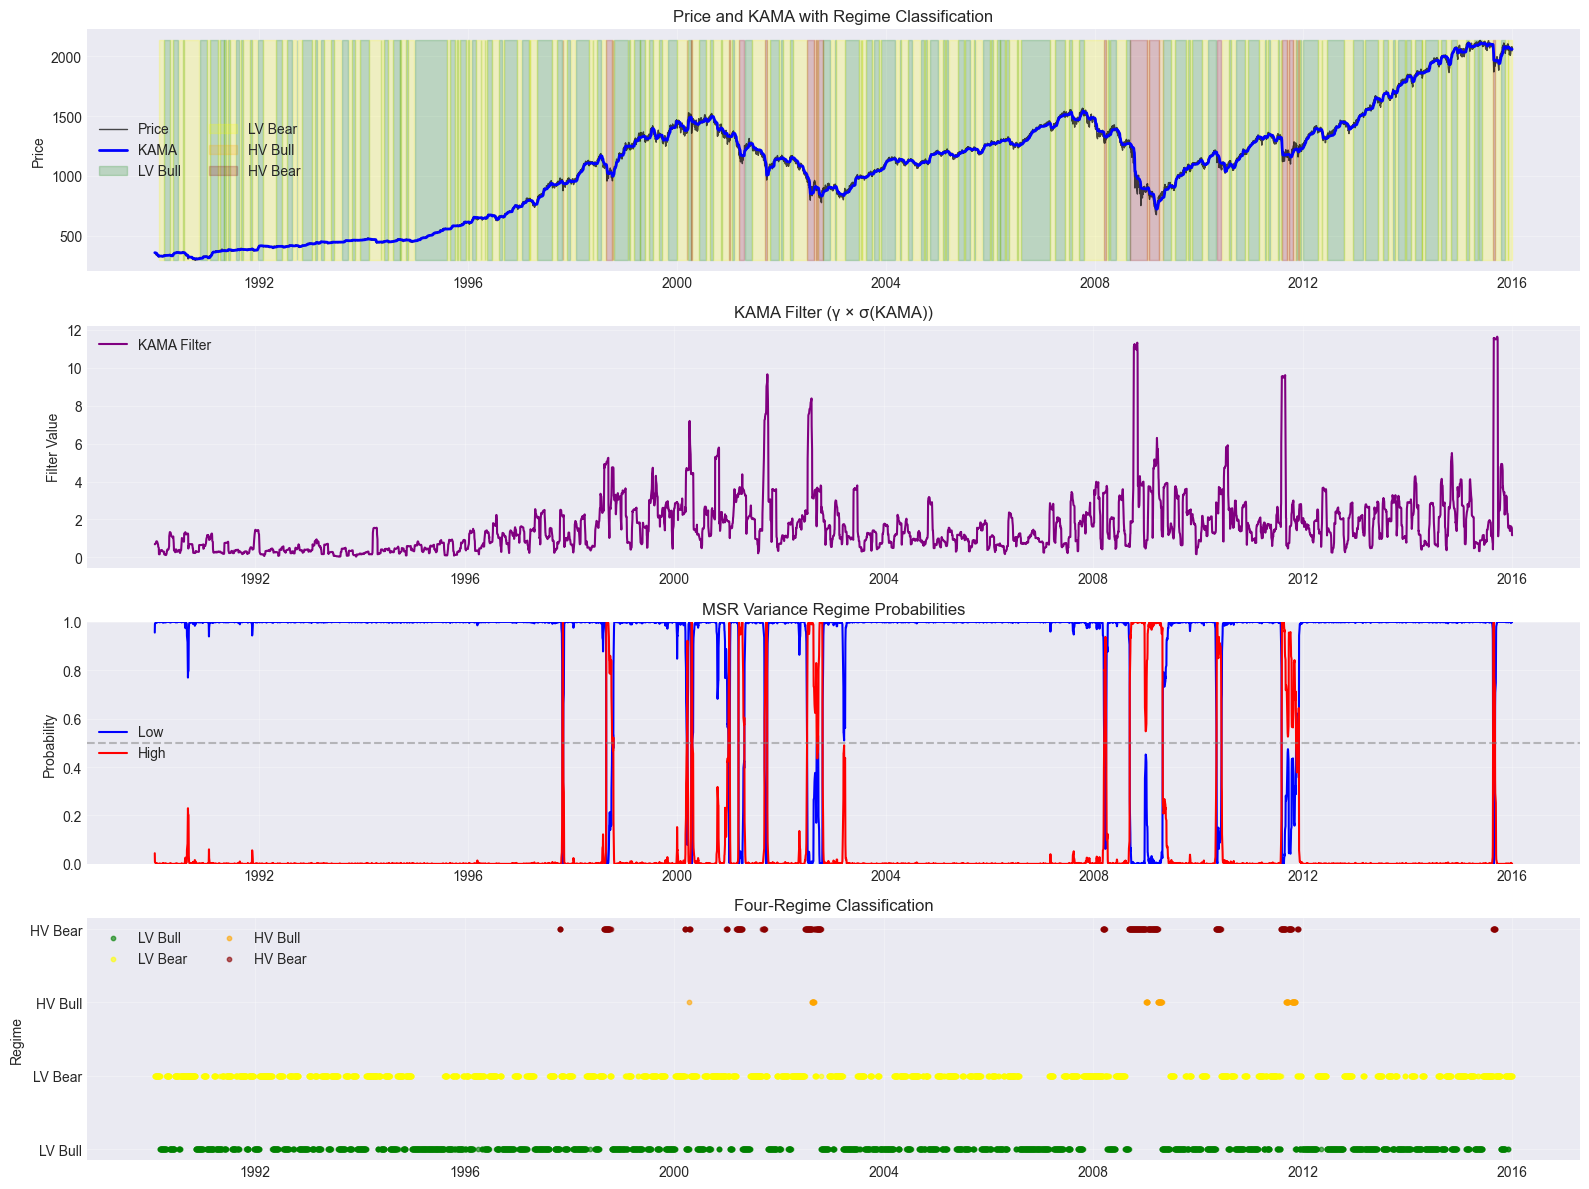

[2/3] Comprehensive Analysis Plot...


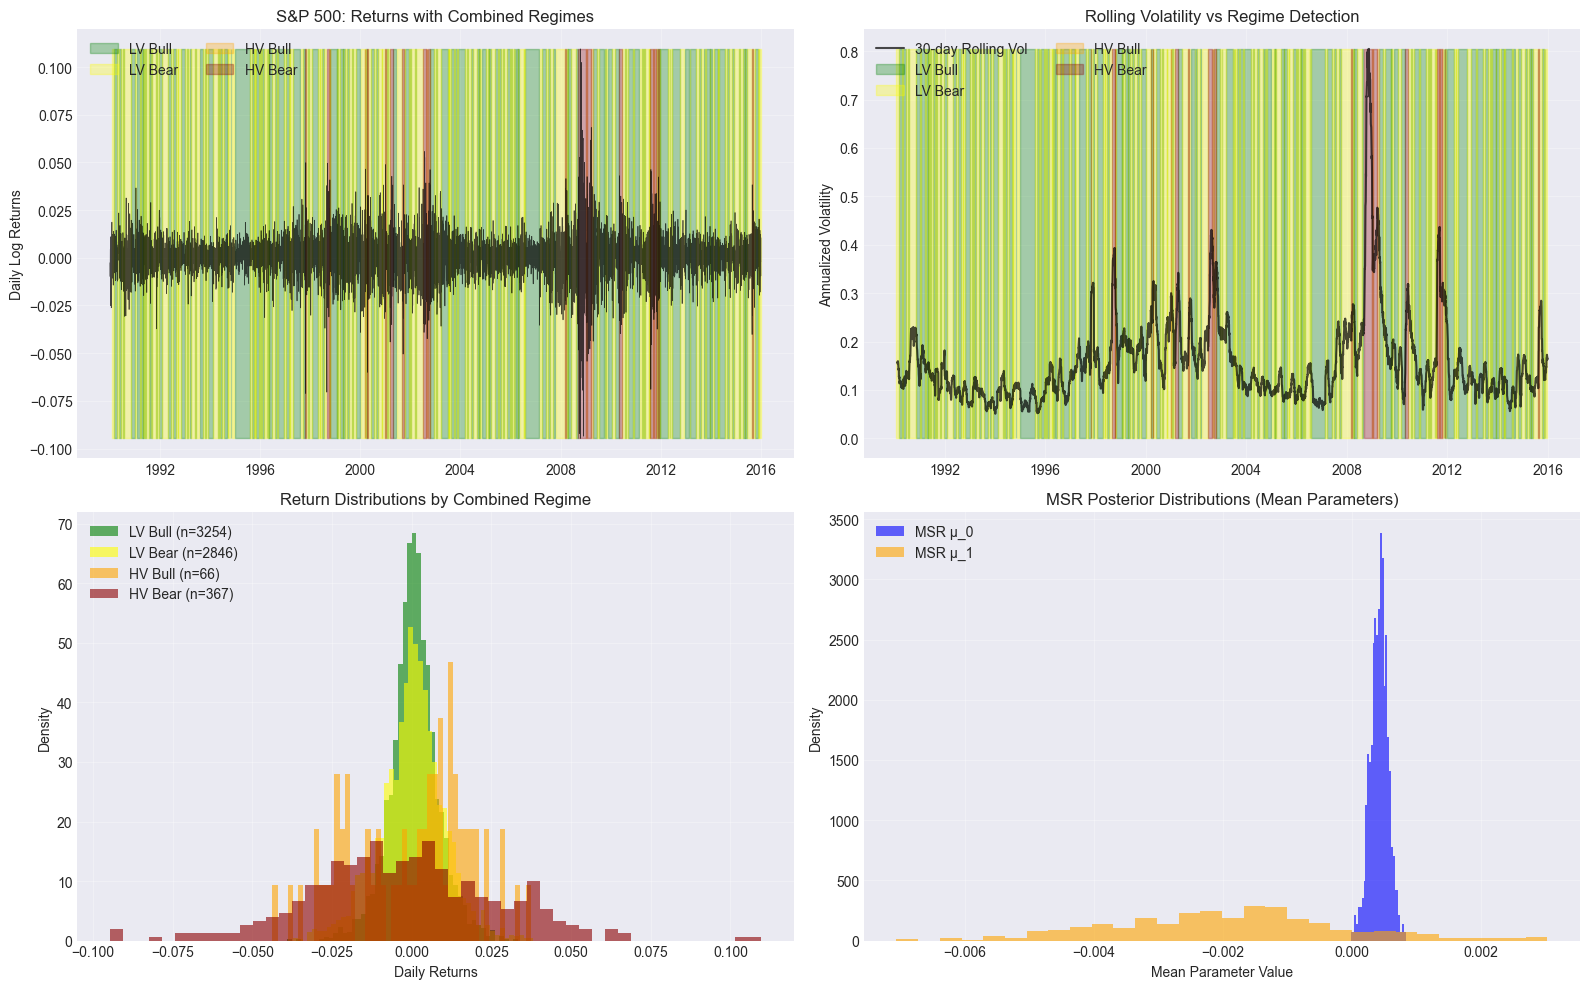

<Figure size 640x480 with 0 Axes>

In [35]:
# ============================================================================
# STEP 8: VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("STEP 7: GENERATING VISUALIZATIONS")
print("="*80)

# Main regime classification plot
print("\n[1/3] Regime Classification Plot...")
model.plot_regimes(figsize=(16, 12))

# Comprehensive analysis plot
print("[2/3] Comprehensive Analysis Plot...")
model.plot_comprehensive_analysis(
    data=data_df,
    regime_probs=regime_probs,
    data_name="S&P 500"
)

'''
# Strategy performance plot
print("[3/3] Strategy Performance Plot...")
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0]
ax1.plot(cumulative_strategy.index, np.exp(cumulative_strategy)-1, 
         label='KAMA+MSR Strategy', linewidth=2, color='blue')
ax1.plot(cumulative_benchmark.index, np.exp(cumulative_benchmark)-1, 
         label='Buy & Hold', linewidth=2, alpha=0.7, color='gray')
ax1.set_title('Cumulative Returns: KAMA+MSR Strategy vs Buy & Hold', fontsize=14, weight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Drawdown
ax2 = axes[1]
strategy_dd = cumulative_strategy - cumulative_strategy.cummax()
benchmark_dd = cumulative_benchmark - cumulative_benchmark.cummax()
ax2.fill_between(strategy_dd.index, strategy_dd, 0, 
                 alpha=0.7, color='blue', label='Strategy Drawdown')
ax2.fill_between(benchmark_dd.index, benchmark_dd, 0, 
                 alpha=0.4, color='gray', label='Benchmark Drawdown')
ax2.set_title('Drawdown Analysis', fontsize=14, weight='bold')
ax2.set_ylabel('Drawdown')
ax2.set_xlabel('Date')
ax2.legend(loc='lower left', fontsize=12)
ax2.grid(True, alpha=0.3)
'''

plt.tight_layout()
plt.show()

### STEP 9: EXPORT RESULTS

In [36]:
# ============================================================================
# STEP 9: EXPORT RESULTS
# ============================================================================
print("\n" + "="*80)
print("STEP 8: EXPORTING RESULTS")
print("="*80)

# Create comprehensive results dataframe
results_df = pd.DataFrame({
    'price': prices,
    'returns': log_returns,
    'regime': model.regime_labels,
    'signal': signals,
    'kama': model.kama_values,
    'kama_filter': model.filter_values
})

# Add regime probabilities
for col in regime_probs.columns:
    results_df[col] = regime_probs[col]

# # Add strategy performance
# results_df['strategy_returns'] = strategy_returns
# results_df['cumulative_strategy'] = cumulative_strategy
# results_df['cumulative_benchmark'] = cumulative_benchmark

# Save to CSV
results_df.to_csv(f'saved_models/KAMA_MSR/results/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes_{burnin}_{n_samples}_{thin}_RESULTS.csv')
print(f"\n✓ Results exported to saved_models/KAMA_MSR/results/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes_{burnin}_{n_samples}_{thin}_RESULTS.csv")

# Save model for later use
import pickle
with open(f'saved_models/KAMA_MSR/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes_{burnin}_{n_samples}_{thin}.pkl', 'wb') as f:
    pickle.dump(model, f)
print(f"✓ Model saved to saved_models/KAMA_MSR/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes_{burnin}_{n_samples}_{thin}.pkl")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


STEP 8: EXPORTING RESULTS

✓ Results exported to saved_models/KAMA_MSR/results/S&P 500_KAMA-MSR_4-regimes_100_500_1_RESULTS.csv
✓ Model saved to saved_models/KAMA_MSR/S&P 500_KAMA-MSR_4-regimes_100_500_1.pkl

ANALYSIS COMPLETE!


# Loading Saved Model

LOADED MODEL INFORMATION

2. KAMA PARAMETERS:
------------------------------
KAMA n: 10
KAMA n_fast: 2
KAMA n_slow: 30
KAMA k_fast: 0.666667
KAMA k_slow: 0.064516

3. FILTER PARAMETERS:
------------------------------
n_lookback: 20
gamma: 0.7

4. MSR PRIORS (After Optimization if Optimized):
-----------------------------------
mean_prior_mean: 0.0
mean_prior_var: 0.1
beta_prior_mean: 0.0
beta_prior_var: 1.0
sigma_prior_shape: 2.0
sigma_prior_scale: 0.1
transition_prior_alpha: 8.0

5. MODEL CONFIGURATION:
------------------------------
use_three_state_msr: False
Number of combined regimes: 4
MSR n_regimes: 2

6. DATA INFORMATION:
------------------------------
Price data length: 6553
Return data length: 6552
Regime labels length: 6533
Regime changes: 290

7. MSR PARAMETERS (Post-Fit):
----------------------------------------
MSR Means (μ):
  Regime 0: 0.000409
  Regime 1: -0.001877

MSR Betas (β):
  Regime 0: -0.0074
  Regime 1: -0.0277

MSR Standard Deviations (σ):
  Regime 0: 0.010654

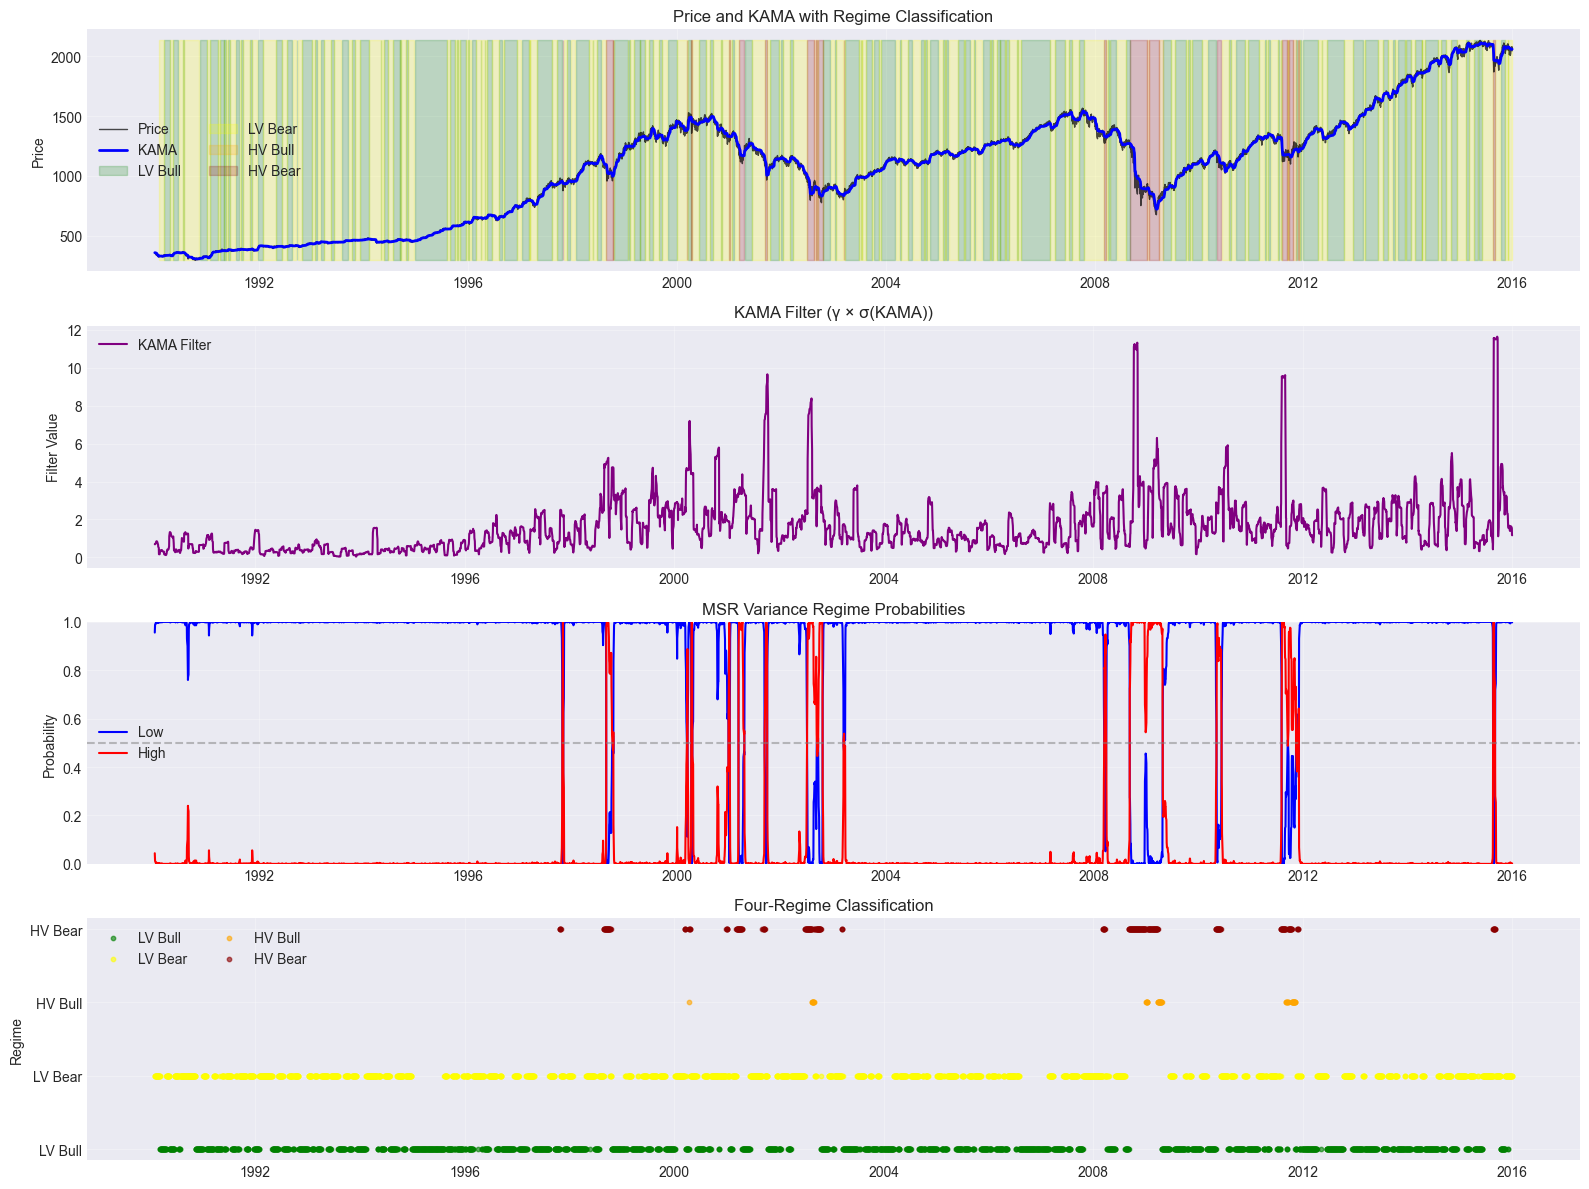

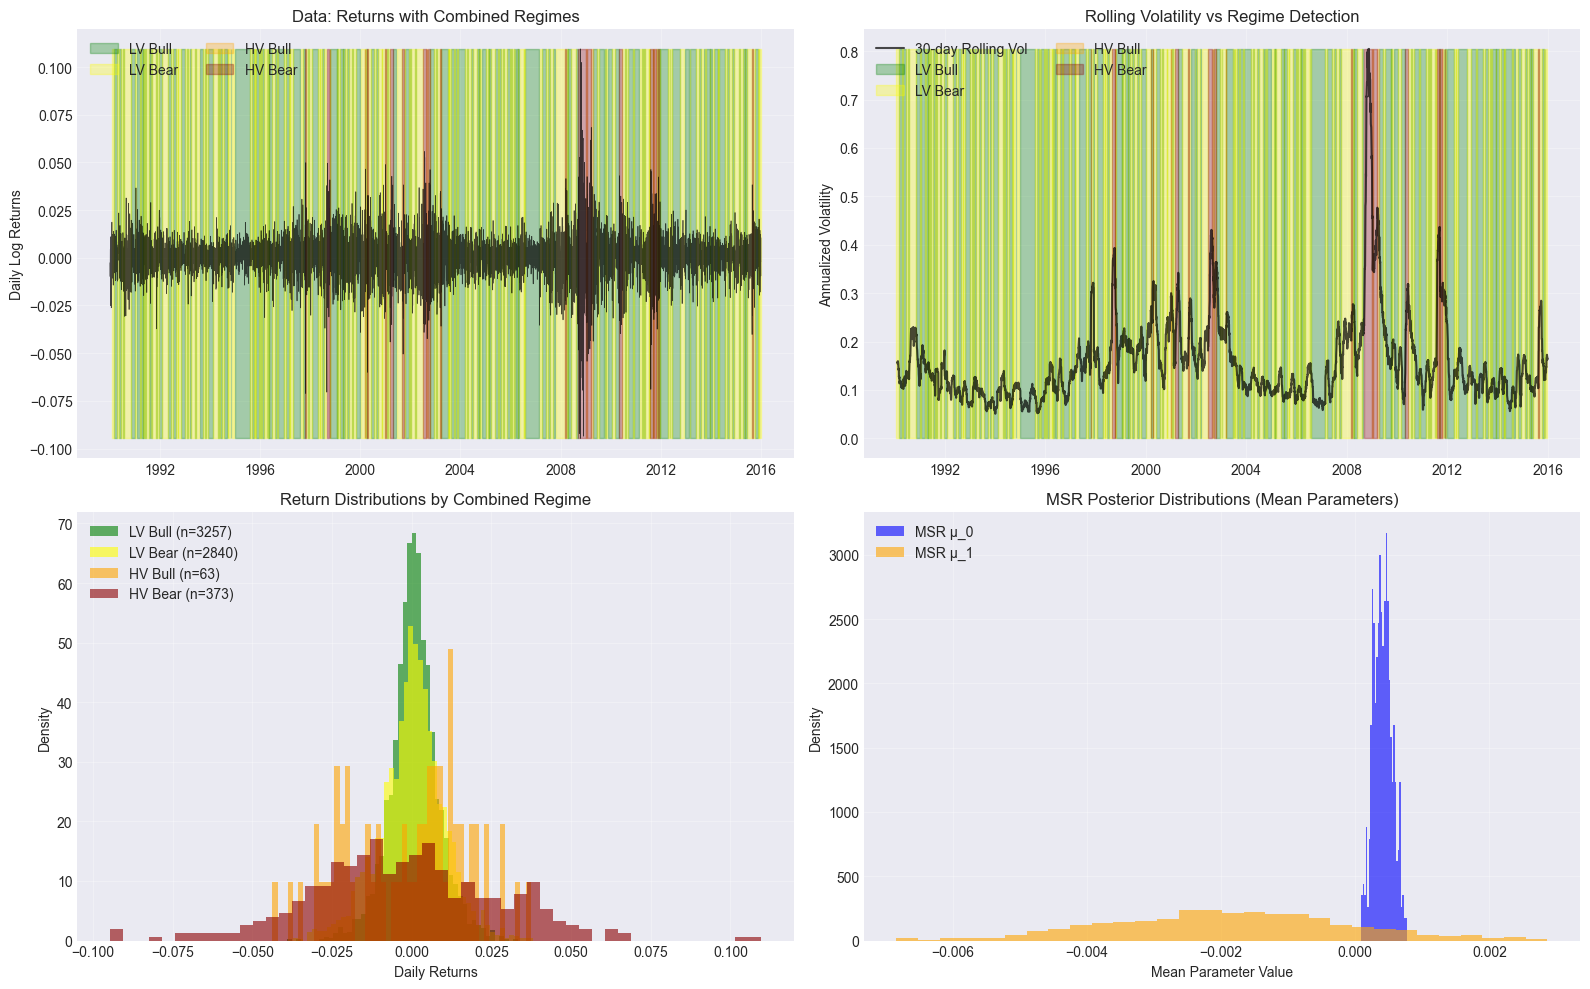

In [41]:
asset_name = 'S&P 500'
n_regimes = 2
pkl_file_path = f'saved_models/KAMA_MSR/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes.pkl'
with open(pkl_file_path, 'rb') as f:
    loaded_model = pickle.load(f)

print("="*60)
print("LOADED MODEL INFORMATION")
print("="*60)

# ============================================================================
# 2. ACCESS KAMA PARAMETERS
# ============================================================================
print("\n2. KAMA PARAMETERS:")
print("-" * 30)
print(f"KAMA n: {loaded_model.kama.n}")
print(f"KAMA n_fast: {loaded_model.kama.n_fast}")
print(f"KAMA n_slow: {loaded_model.kama.n_slow}")
print(f"KAMA k_fast: {loaded_model.kama.k_fast:.6f}")
print(f"KAMA k_slow: {loaded_model.kama.k_slow:.6f}")

# ============================================================================
# 3. ACCESS FILTER PARAMETERS
# ============================================================================
print("\n3. FILTER PARAMETERS:")
print("-" * 30)
print(f"n_lookback: {loaded_model.n_lookback}")
print(f"gamma: {loaded_model.gamma}")

# ============================================================================
# 4. ACCESS PRIORS (AFTER OPTIMIZATION)
# ============================================================================
print("\n4. MSR PRIORS (After Optimization if Optimized):")
print("-" * 35)

# The priors used during model initialization
priors = loaded_model.msr.priors
for param, value in priors.items():
    print(f"{param}: {value}")

# ============================================================================
# 5. ACCESS MODEL CONFIGURATION
# ============================================================================
print("\n5. MODEL CONFIGURATION:")
print("-" * 30)
print(f"use_three_state_msr: {loaded_model.use_three_state_msr}")
print(f"Number of combined regimes: {loaded_model.n_combined_regimes}")
print(f"MSR n_regimes: {loaded_model.msr.n_regimes}")

# ============================================================================
# 6. CHECK DATA DIMENSIONS
# ============================================================================
print("\n6. DATA INFORMATION:")
print("-" * 30)
if loaded_model.prices is not None:
    print(f"Price data length: {len(loaded_model.prices)}")
    print(f"Return data length: {len(loaded_model.returns)}")
    print(f"Regime labels length: {len(loaded_model.regime_labels.dropna())}")
    print(f"Regime changes: {(loaded_model.regime_labels.diff() != 0).sum()}")

# ============================================================================
# 7. ACCESS MSR PARAMETERS (AFTER FITTING)
# ============================================================================
print("\n7. MSR PARAMETERS (Post-Fit):")
print("-" * 40)
print("MSR Means (μ):")
for i, mean in enumerate(loaded_model.msr.means):
    print(f"  Regime {i}: {mean:.6f}")

print("\nMSR Betas (β):")
for i, beta in enumerate(loaded_model.msr.betas):
    print(f"  Regime {i}: {beta:.4f}")

print("\nMSR Standard Deviations (σ):")
for i, std in enumerate(loaded_model.msr.stds):
    print(f"  Regime {i}: {std:.6f}")

print("\nMSR Transition Probabilities:")
print("          To Regime:")
print("From      0       1" + ("       2" if loaded_model.msr.n_regimes == 3 else ""))
print("Regime")
for i in range(loaded_model.msr.n_regimes):
    row = f"  {i}    "
    for j in range(loaded_model.msr.n_regimes):
        row += f"  {loaded_model.msr.transition_probs[i,j]:.3f}"
    print(row)


# ============================================================================
# 8. RUN ANALYSIS ON LOADED MODEL
# ============================================================================
print("\n8. RUNNING FULL ANALYSIS ON LOADED MODEL...")
loaded_model.analyze_results()  # If you have data loaded
loaded_model.regime_characteristics()
loaded_model.plot_regimes()
loaded_model.plot_comprehensive_analysis()
